In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random



In [2]:
# Read data
df = kpd.read_csv('Simulated_Cashflow.txt',sep=';')

In [3]:
df.head()

,ClNr,LoB,cc,AY,AQ,age,inj_part,RepDel,Pay00,Pay01,...,Open02,Open03,Open04,Open05,Open06,Open07,Open08,Open09,Open10,Open11
0,1.0,2,49,1994,2,32,71,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,2,46,1994,2,15,34,0,651,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,3,50,1994,1,39,14,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2,41,1994,3,36,33,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5.0,3,20,1994,1,59,53,0,4455,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df = df.loc[(df['RepDel']+df['AY'])<= 2005]
len(df)

497549

In [5]:
df_array = np.array(df)

In [6]:
column_indices = {c: i for i, c in enumerate(df.columns)}
pay00i = column_indices['Pay00']

**Remove recoveries**

In [7]:
def remove_recoveries(df_arr):
    pay00i = column_indices['Pay00']
    for dev_year in range(11,0,-1):
        index = pay00i + dev_year
        payments = df_arr[:,index] 
        recoveries = np.where(payments < 0)[0]
        for i in recoveries:
            df_arr[i,index-1] += df_arr[i,index]
            df_arr[i,index] = 0
        payments = df_arr[:,index] 
    return df_arr

In [8]:
df_array = remove_recoveries(df_array)
df_new = pd.DataFrame(df_array,columns = df.columns)

In [9]:
freq = np.zeros(12)

for rep_del in range(12):
    tmp_arr = np.array(df_new.loc[df_new['RepDel'] == rep_del])
    tmp2 = []
    
    pay00i = column_indices['Pay00']
    for i in range (rep_del,12):
        tmp2.append(len(np.where(tmp_arr[:,pay00i + i] > 0)[0]))
        
    tmp2 = np.pad(tmp2,(0,rep_del))
    
    freq += tmp2
print(freq)

[320740.  80878.  13817.   7091.   4356.   3059.   2255.   1767.   1375.
   1081.    936.    800.]


**Litigation factor**

In [10]:
# Parameters
lit_chance = 0.5
np.random.seed(0)
random.seed(69)
weights = np.linspace(1.3,1.8,num=11)

# Add 12 new columns
npb = np.shape(df_array)[0]  # number of claims
nc = np.shape(df_array)[1]  #number of columns
df_new = np.zeros((npb,nc+13)) #  + lit_year_relative
df_new[:,:-13] = df_array

# Draw probability
probs = np.random.uniform(size = npb)
ids = np.where(probs < lit_chance)[0]

In [11]:
lit_start_relative = np.zeros(11)
for i in ids:
    rep_del = int(df_array[i,column_indices['RepDel']])
    payments = df_array[i,(pay00i+1+rep_del):pay00i+12]
    if np.sum(payments) != 0:
        tmp = np.where(payments > 0)[0]
        choice = random.choice(tmp) # add 1 because
        weight = weights[choice]
        df_new[i,-1] = choice + 1
        lit_start = choice + 1 + rep_del
        
        df_new[i,pay00i+lit_start:pay00i+12] = df_new[i,pay00i+lit_start:pay00i+12]*weight
        df_new[i,nc+lit_start:nc+12] = np.ones(12-lit_start)
        
        lit_start_relative[choice] += 1

        
df_new[:,-1][df_new[:,-1] == 0] = np.NaN

In [12]:
lit_start_relative

array([36392.,  3107.,  1277.,   597.,   409.,   262.,   184.,   131.,
         102.,    72.,    64.])

In [13]:
# Check how many claims there are that dont only payment in first...
count = 0
for i in range(len(df)):
    rep_del = int(df_array[i,column_indices['RepDel']])
    payments = df_array[i,(pay00i+1+rep_del):pay00i+12]
    if np.sum(payments) != 0:
        count +=1
print(count)

84909


In [14]:
sum(lit_start_relative)

42597.0

**Normalization of other factors**

In [15]:
# Normalize Accident Year
# dont run this shit more than once

df_new[:,column_indices['AY']] = df_new[:,column_indices['AY']] - 1993

In [16]:
# Shift AQ so that [1:4] becomes [0:3]
# dont run this shit more than once

df_new[:,column_indices['AQ']] = df_new[:,column_indices['AQ']] - 1

In [17]:
# Shift LoB so that [1:4] becomes [0:3]
# dont run this shit more than once

df_new[:,column_indices['LoB']] = df_new[:,column_indices['LoB']] - 1

In [18]:
# Shift Injury parts
# dont run this shit more than once
inj_part = df_new[:,column_indices['inj_part']].astype(int)
inj_new = inj_part
y = np.bincount(inj_part)
ii = np.nonzero(y)[0]
for i in range(len(ii)):
  idx = np.where(inj_part == ii[i])[0]
  inj_new[idx] = i
df_new[:,column_indices['inj_part']] = inj_new

In [19]:
# Shift Company code
# dont run this shit more than once
cc = df_new[:,column_indices['cc']].astype(int)
cc_new = cc
y = np.bincount(cc)
ii = np.nonzero(y)[0]
for i in range(len(ii)):
  idx = np.where(cc == ii[i])[0]
  cc_new[idx] = i
df_new[:,column_indices['cc']] = cc_new

**Export Dataframe**

In [20]:
df = pd.DataFrame(df_new, columns = ['ClNr','LoB','cc','AY','AQ','age','inj_part','RepDel',
                                     'Pay00','Pay01','Pay02','Pay03','Pay04','Pay05','Pay06','Pay07','Pay08','Pay09','Pay10','Pay11',
                                     'Open00','Open01','Open02','Open03','Open04','Open05','Open06','Open07','Open08','Open09','Open10','Open11',
                                     'Lit00','Lit01','Lit02','Lit03','Lit04','Lit05','Lit06','Lit07','Lit08','Lit09','Lit10','Lit11','lit_year_relative'])

In [21]:
df['k_year'] = (12-df['AY']).astype(int)
df['UC'] = df['Pay00']+df['Pay01']+df['Pay02']+df['Pay03']+df['Pay04']+df['Pay05']+df['Pay06']+ df['Pay07']+df['Pay08']+df['Pay09']+df['Pay10']+df['Pay11']

In [22]:
df[(df['Open00']==0) & (df['Pay00']==df['UC'])].describe()

,ClNr,LoB,cc,AY,AQ,age,inj_part,RepDel,Pay00,Pay01,...,Lit05,Lit06,Lit07,Lit08,Lit09,Lit10,Lit11,lit_year_relative,k_year,UC
count,260712.000000,260712.000000,260712.000000,260712.000000,260712.000000,260712.000000,260712.000000,260712.0,260712.000000,260712.0,...,260712.0,260712.0,260712.0,260712.0,260712.0,260712.0,260712.0,0.0,260712.000000,260712.000000
mean,250265.996410,1.410587,23.704670,6.599700,0.819176,35.058106,20.024145,0.0,764.376028,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5.400300,764.376028
std,144697.044738,1.088657,14.142284,3.454393,0.820244,13.099687,11.529403,0.0,1837.398263,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.454393,1837.398263
min,1.000000,0.000000,0.000000,1.000000,0.000000,15.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.000000,0.000000
25%,125114.250000,1.000000,14.000000,4.000000,0.000000,24.000000,10.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.000000,0.000000
50%,249793.500000,1.000000,20.000000,7.000000,1.000000,34.000000,20.000000,0.0,238.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,5.000000,238.000000
75%,375895.500000,2.000000,37.000000,10.000000,1.000000,44.000000,29.000000,0.0,741.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,8.000000,741.000000
max,500914.000000,3.000000,50.000000,12.000000,3.000000,70.000000,45.000000,0.0,117801.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11.000000,117801.000000


In [23]:
df.describe()

,ClNr,LoB,cc,AY,AQ,age,inj_part,RepDel,Pay00,Pay01,...,Lit05,Lit06,Lit07,Lit08,Lit09,Lit10,Lit11,lit_year_relative,k_year,UC
count,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,4.975490e+05,...,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,497549.000000,42597.000000,497549.000000,4.975490e+05
mean,248961.059538,1.446481,23.738763,6.568380,1.493202,35.115366,20.126480,0.079554,933.434478,5.743544e+02,...,0.083841,0.084388,0.084796,0.085033,0.085274,0.085451,0.085614,1.340940,5.431620,2.048221e+03
std,143903.022258,1.116677,14.133441,3.435957,1.115301,13.151338,11.636276,0.305253,5244.109385,6.784144e+03,...,0.277149,0.277969,0.278578,0.278931,0.279289,0.279552,0.279793,1.121059,3.435957,2.032031e+04
min,1.000000,0.000000,0.000000,1.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00
25%,124394.000000,0.000000,14.000000,4.000000,0.000000,24.000000,10.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000e+00
50%,248803.000000,1.000000,20.000000,7.000000,1.000000,34.000000,20.000000,0.000000,149.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,2.630000e+02
75%,373242.000000,2.000000,37.000000,10.000000,2.000000,45.000000,29.000000,0.000000,635.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000,8.980000e+02
max,500914.000000,3.000000,50.000000,12.000000,3.000000,70.000000,45.000000,11.000000,670281.000000,1.860207e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000,11.000000,4.750268e+06


In [24]:
df[df['inj_part']==6]

,ClNr,LoB,cc,AY,AQ,age,inj_part,RepDel,Pay00,Pay01,...,Lit05,Lit06,Lit07,Lit08,Lit09,Lit10,Lit11,lit_year_relative,k_year,UC
286,287.0,3.0,44.0,1.0,0.0,61.0,6.0,0.0,1302.0,627.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11,1929.0
448,449.0,3.0,29.0,1.0,2.0,26.0,6.0,0.0,332.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11,332.0
503,504.0,2.0,9.0,1.0,1.0,35.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11,0.0
518,519.0,1.0,25.0,1.0,0.0,26.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11,0.0
548,549.0,3.0,4.0,1.0,0.0,56.0,6.0,0.0,215.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11,215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497183,500510.0,3.0,42.0,12.0,0.0,27.0,6.0,0.0,510.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,510.0
497238,500575.0,3.0,3.0,12.0,0.0,15.0,6.0,0.0,1956.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,1956.0
497288,500628.0,1.0,15.0,12.0,2.0,28.0,6.0,0.0,647.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,647.0
497511,500873.0,2.0,29.0,12.0,3.0,44.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0.0


In [25]:
df.to_csv(r'Simulated_Cashflow_Lit.txt',sep=';',index = False)

**Check litigation data**

In [49]:
for lityear in df.lit_year_relative.unique():
    print(df[df['lit_year_relative']==lityear].UC.mean())

nan
4610.273587601708
23776.284470550352
51763.80317848411
67938.47480916033
45209.36834170851
37935.782615505086
158063.19444444444
59006.13187022901
77602.75108695654
90265.36568627448
73308.221875


In [ ]:
df.loc[df.lit_year_relative != np.NaN]

In [ ]:
lit_sum = np.sum(df_new[:,32:44],axis =1)

idx = np.where(lit_sum > 0)[0]
df_lit = pd.DataFrame(df_new[idx], columns = ['ClNr','LoB','cc','AY','AQ','age','inj_part','RepDel',
                                     'Pay00','Pay01','Pay02','Pay03','Pay04','Pay05','Pay06','Pay07','Pay08','Pay09','Pay10','Pay11',
                                     'Open00','Open01','Open02','Open03','Open04','Open05','Open06','Open07','Open08','Open09','Open10','Open11',
                                     'Lit00','Lit01','Lit02','Lit03','Lit04','Lit05','Lit06','Lit07','Lit08','Lit09','Lit10','Lit11',
                                     'UC'])
df_lit.head(50)


**Visualizing Data**

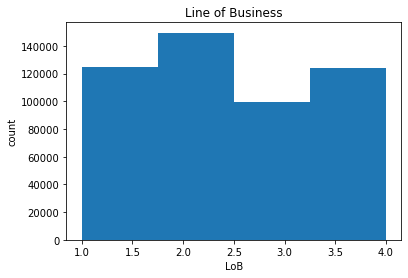

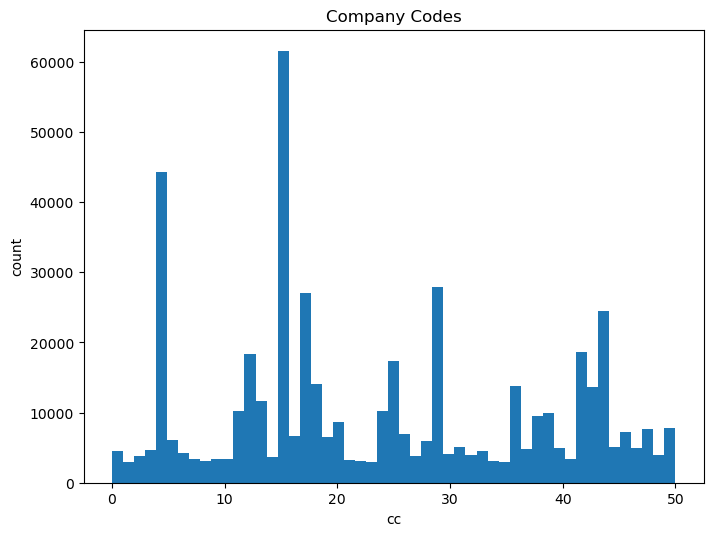

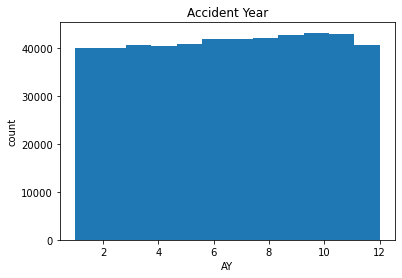

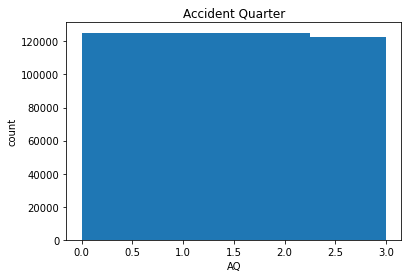

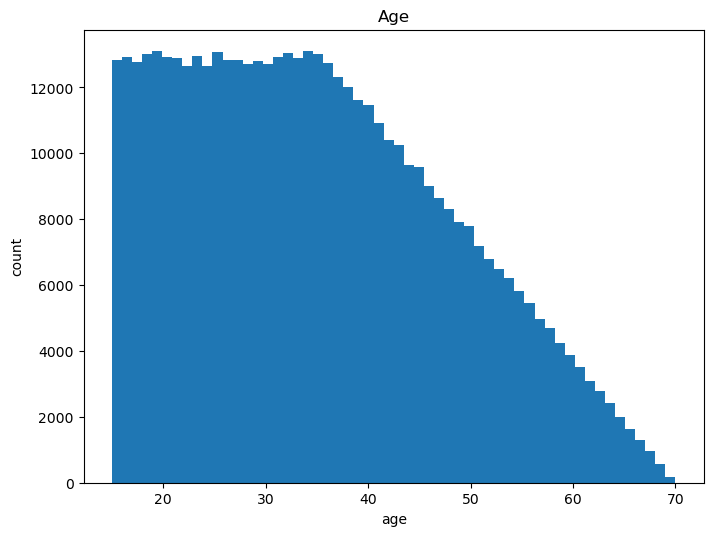

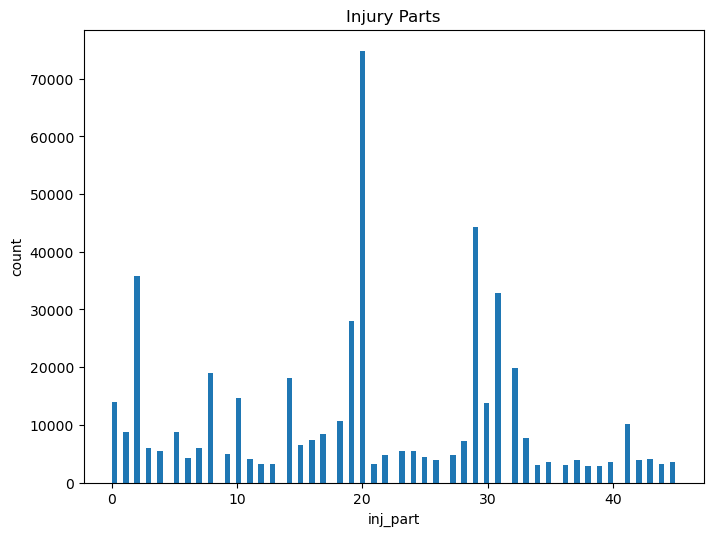

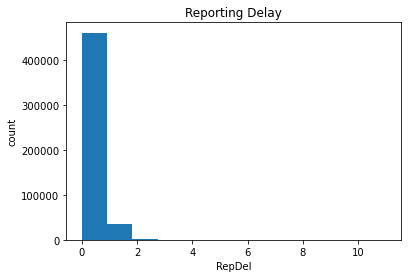

In [61]:
# Plotting of features
plt.hist(df.LoB,bins = 4)
plt.title('Line of Business')
plt.ylabel('count')
plt.xlabel('LoB')
plt.show()

plt.figure(figsize=(8, 6), dpi=100)
plt.hist(df.cc,bins = 51)
plt.title('Company Codes')
plt.ylabel('count')
plt.xlabel('cc')
plt.show()

plt.hist(df.AY,bins = 12)
plt.title('Accident Year')
plt.ylabel('count')
plt.xlabel('AY')
plt.show()

plt.hist(df.AQ,bins = 4)
plt.title('Accident Quarter')
plt.ylabel('count')
plt.xlabel('AQ')
plt.show()

plt.figure(figsize=(8, 6), dpi=100)
plt.hist(df.age,bins = 70-15+1)
plt.title('Age')
plt.ylabel('count')
plt.xlabel('age')
plt.show()

plt.figure(figsize=(8, 6), dpi=100)
plt.hist(df.inj_part,bins = 100)
plt.title('Injury Parts')
plt.ylabel('count')
plt.xlabel('inj_part')
plt.show()

plt.hist(df.RepDel,bins = 12)
plt.title('Reporting Delay')
plt.ylabel('count')
plt.xlabel('RepDel')
plt.show()